In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import multidop
import pyart
import read_brazil_radar as rbr
import tempfile
import os
import glob
import time
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### Reading radar files

In [2]:
filenames = open("filenames.txt").read().split('\n')

In [3]:
radar_1 = pyart.aux_io.read_gamic(filenames[0])
radar_2 = rbr.read_rainbow_hdf5(filenames[1])
print(radar_1.fields.keys(), radar_2.fields.keys())

['spectrum_width', 'corrected_velocity', 'corrected_reflectivity', 'reflectivity'] ['corrected_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'filtered_differential_phase', 'spectrum_width', 'reflectivity', 'differential_reflectivity', 'specific_differential_phase', 'velocity']


### Performing corrections

In [4]:
cp = deepcopy(radar_1.fields['corrected_reflectivity']['data'])
radar_1.add_field_like('corrected_reflectivity', 'DT', cp, replace_existing=True)
gatefilter = pyart.correct.GateFilter(radar_1)
gatefilter.exclude_masked('corrected_reflectivity')
corr_vel = pyart.correct.dealias_region_based(radar_1, vel_field='corrected_velocity',
                                              keep_original=False, gatefilter=gatefilter,
                                              centered=True)
radar_1.add_field('VT', corr_vel, replace_existing=True)

/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 1.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 2.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 3.
  warnings.warn(msg, UserWarning)
/home/camila/anaconda2/lib/python2.7/site-packages/pyart/correct/region_dealias.py:267: UserWarning: Velocities outside of the Nyquist interval found in sweep 4.
  warnings.warn(msg, UserWarning)
/home/camila/anacond

In [5]:
cp = deepcopy(radar_2.fields['reflectivity']['data'])
radar_2.add_field_like('reflectivity', 'DT', cp, replace_existing=True)
gatefilter = pyart.correct.GateFilter(radar_2)
gatefilter.exclude_masked('reflectivity')
corr_vel = pyart.correct.dealias_region_based(radar_2, vel_field='velocity',
                                              keep_original=False, gatefilter=gatefilter,
                                              centered=True)
radar_2.add_field('VT', corr_vel, replace_existing=True)

### Comparing corrections: São Roque

In [6]:
xlim, ylim = [[-47.5,-46.5], [-23.3,-22.5]]

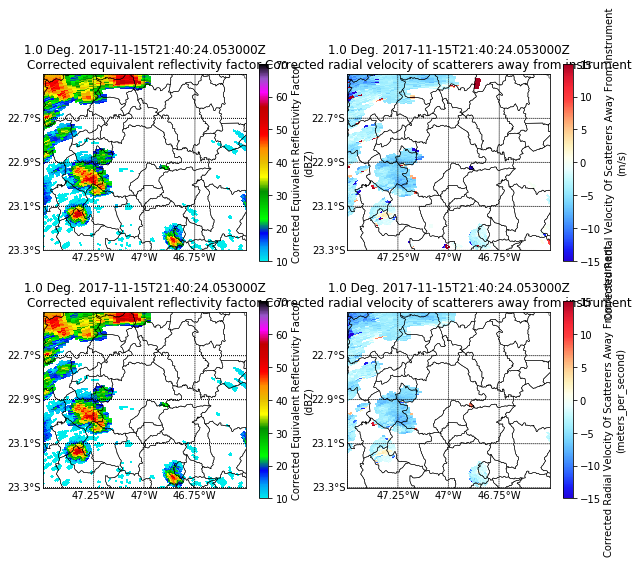

In [7]:
display = pyart.graph.RadarMapDisplay(radar_1)
fig = plt.figure(figsize=(10,8))
fig.set_facecolor('w')

ax1 = fig.add_subplot(221)
display.plot_ppi_map('corrected_reflectivity', 1, vmin=10, vmax=70, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25))

ax2 = fig.add_subplot(222)
display.plot_ppi_map('corrected_velocity', 1, vmin=-15, vmax=15, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25))

ax3 = fig.add_subplot(223)
display.plot_ppi_map('DT', 1, vmin=10, vmax=70, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25),
                     cmap='pyart_NWSRef')

ax4 = fig.add_subplot(224)
display.plot_ppi_map('VT', 1, vmin=-15, vmax=15, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25),
                     cmap='pyart_BuDRd18')

### Comparing corrections: CTH

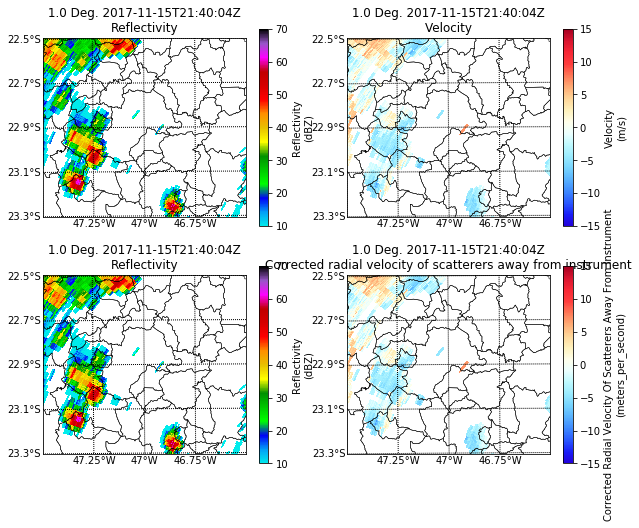

In [8]:
display = pyart.graph.RadarMapDisplay(radar_2)
fig = plt.figure(figsize=(10,8))
fig.set_facecolor('w')

ax1 = fig.add_subplot(221)
display.plot_ppi_map('reflectivity', 0, vmin=10, vmax=70, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25))

ax2 = fig.add_subplot(222)
display.plot_ppi_map('velocity', 0, vmin=-15, vmax=15, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25))

ax3 = fig.add_subplot(223)
display.plot_ppi_map('DT', 0, vmin=10, vmax=70, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25),
                     cmap='pyart_NWSRef')

ax4 = fig.add_subplot(224)
display.plot_ppi_map('VT', 0, vmin=-15, vmax=15, shapefile="../Data/GENERAL/shapefiles/sao_paulo",
                     max_lat=ylim[1], min_lat=ylim[0], min_lon=xlim[0], max_lon=xlim[1],
                     lat_lines=np.arange(ylim[0], ylim[1], .2), lon_lines=np.arange(xlim[0], xlim[1], .25),
                     cmap='pyart_BuDRd18')

In [9]:
radar_1.fields['DT']['missing_value'] = 1.0 * radar_1.fields['DT']['_FillValue']
radar_2.fields['DT']['missing_value'] = 1.0 * radar_2.fields['DT']['data'].fill_value
radar_2.fields['DT']['_FillValue'] = radar_2.fields['DT']['data'].fill_value
radar_1.fields['VT']['missing_value'] = 1.0 * radar_1.fields['VT']['_FillValue']
radar_2.fields['VT']['missing_value'] = 1.0 * radar_2.fields['VT']['data'].fill_value
radar_2.fields['VT']['_FillValue'] = radar_2.fields['VT']['data'].fill_value

### Grid the volumes and add azimuths and elevations

In [10]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000),
               fields=['DT', 'VT'], origin=None):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        gridding_algo='map_gates_to_grid', grid_origin_alt=0.0)
    print(time.time()-bt, 'seconds to grid radar')
    return grid

In [11]:
grid_1 = grid_radar(radar_1, origin=(radar_2.latitude['data'][0], radar_2.longitude['data'][0]),
                    xlim=(-100000, 50000), ylim=(0, 150000), grid_shape=(20, 151, 151))
grid_2 = grid_radar(radar_2, origin=(radar_2.latitude['data'][0], radar_2.longitude['data'][0]),
                    xlim=(-100000, 50000), ylim=(0, 150000), grid_shape=(20, 151, 151))

/home/camila/anaconda2/lib/python2.7/site-packages/pyart/core/transforms.py:632: RuntimeWarning: invalid value encountered in sqrt
  rho = np.sqrt(x*x + y*y)


1.21376013756 seconds to grid radar
2.02211499214 seconds to grid radar


In [12]:
grid_1 = multidop.angles.add_azimuth_as_field(grid_1)
grid_2 = multidop.angles.add_azimuth_as_field(grid_2)
grid_1 = multidop.angles.add_elevation_as_field(grid_1)
grid_2 = multidop.angles.add_elevation_as_field(grid_2)

In [13]:
pyart.io.write_grid('sr.nc', grid_1)
pyart.io.write_grid('cth.nc', grid_2)

In [45]:
# You don't have to define everything. Most of these keywords are default values.
# If you don't define something the program will provide a default value.
# Check parameters.py for what keyword default values are.
localfile = tempfile.NamedTemporaryFile()
pd = {'dir': './',
      'x': [-150000.0, 1000.0, 201],
      'y': [0.0, 1000.0, 201],
      'z': [1000.0, 1000.0,  20],
      'grid': [grid_1.origin_longitude['data'][0], grid_1.origin_latitude['data'][0], 0.0],
      'files': ['sr.nc',
                'cth.nc'],
      'radar_names': ['SR', 'CTH'],
      'refl': 'DT',  # Name of reflectivity field. Must be common between radars.
      'vt': 'VT',  # Name of velocity field. Must be common between radars.
      'bgfile': None,
      'writeout': localfile.name,
      'min_cba': 20.0,  # Minimum beam-crossing angle
      'calc_params': 'calc.dda',
      'anel': 1,
      'laplace': 0,
      'read_dataweights': 2,
      'max_dist': 10.0,
      'cutoff': 0.0,
      'UT': 0.0,
      'VT': 0.0,
      'output_error': 0,
      'weak_height': -1,
      'upper_bc': 1,
      'itmax_frprmn': [200, 10],
      'itmax_dbrent': 200,
      'C1b': 1.0,  # Data weighting factor
      'C2b': 10.0,  # Mass continuity weighting factor
      'C3b': 0,  # Vorticity weighting factor
      'C4b': 1.0,  # Horizontal smoothing factor
      'C5b': 0.0,  # Vertical smoothing factor
      'C8b': 0.0,  # Sounding factor
      'vary_weights': 0,
      'filter': ['none', '', ''],
      'cvg_opt_bg': [1, 1, 1],
      'cvg_sub_bg': [0, 0, 0],
      'cvg_opt_fil': [0, 1, 1],
      'cvg_sub_fil': [0, 0, 0],
      'cvg_bg': [0, 0, 0],
      'cvg_fil': [0, 0, 0],
      'sseq_trip': [1.0, 1.0, 0.0]
     }
pf = multidop.parameters.ParamFile(pd, 'example.dda')
pf = multidop.parameters.CalcParamFile(pd, 'calc.dda')

In [46]:
# Unfortunately, text output from the analysis engine (DDA) will not display
# until after the program completes. Expect this step to take several minutes.
bt = time.time()
multidop.execute.do_analysis('example.dda', cmd_path='src/DDA')
print((time.time()-bt)/60.0, 'minutes to process')

DDA 0.9.0
./DDA: reading calculation parameters from calc.dda.
Changing working directory to ./
x: -150000.000000 to 50000.000000 in 200 steps of 1000.000000
y: 0.000000 to 200000.000000 in 200 steps of 1000.000000
z: 1000.000000 to 20000.000000 in 19 steps of 1000.000000
z_min=1000, cutoff=0
UT=0, VT=0
Anelastic mass cons
First-order smoothness constraint
Minimum beam crossing angle = 20 degrees
Py-ART grids for analyis and all radars must match to within (dx, dy, dz) < (10 10 10) meters.
0.00179331700007 minutes to process


In [23]:
# Unfortunately, text output from the analysis engine (DDA) will not display
# until after the program completes. Expect this step to take several minutes.
bt = time.time()
multidop.execute.do_analysis('example.dda', cmd_path='src/DDA')
print((time.time()-bt)/60.0, 'minutes to process')

DDA 0.9.0
./DDA: reading calculation parameters from calc.dda.
Changing working directory to ./
x: -100000.000000 to 50000.000000 in 150 steps of 1000.000000
y: 0.000000 to 150000.000000 in 150 steps of 1000.000000
z: 1000.000000 to 20000.000000 in 19 steps of 1000.000000
z_min=1000, cutoff=0
UT=0, VT=0
Anelastic mass cons
First-order smoothness constraint
Minimum beam crossing angle = 20 degrees
Py-ART grids for analyis and all radars must match to within (dx, dy, dz) < (10 10 10) meters.
Reading Py-ART filesr.nc
cth.nc

Radar positions:  (-114195,-581.29) (0.120191,-0.0946686)
Computing coverage: 6358 verification points out of 456020 total points.
radar0 8435 obs. radar1 38676 obs. 47111 total obs.
Analyzed obs = 47111. Mean Vr = 5.30382
C1b=1 C2b=10 C3b=0 C4b=1 C5b=0 C6b=0 C7b=1 C8b=0
C2a=10 C3a=0 C4a=1 C5a=0 C6a=0 C7a=1 C8a=0
Weighting all obs equally!
GradCheck: rchek = 1e+10. fx1 = 8111.99
GradCheck: gxnn = 1346.45
GradCheck: j = 1. fx2 = 6.295e+19. ffff = 4.676e+07
GradCheck: j

In [24]:
# Baseline output is not CF or Py-ART compliant. This function fixes that.
# This is why we wrote the original output to a tempfile that can be safely removed.
# The final grid will have all wind solutions outside the coverage region masked.
fname = 'cf_compliant_grid.nc'
final_grid = multidop.grid_io.make_new_grid([grid_1, grid_2], localfile.name)
final_grid.write(fname)
localfile.close()

In [25]:
pyart_grid = pyart.io.read_grid(fname)
pyart_grid =final_grid
print(pyart_grid.fields.keys())

['eastward_wind', 'upward_air_velocity', 'northward_wind', 'reflectivity']


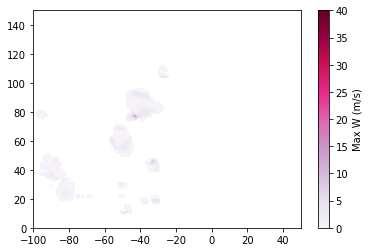

In [26]:
cs = plt.pcolormesh(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'],
                    np.amax(pyart_grid.fields['upward_air_velocity']['data'], axis=0),
                    vmin=0, vmax=40, cmap='PuRd')
plt.colorbar(cs, label='Max W (m/s)')

Text(0,0.5,'Distance north of CTH (km)')

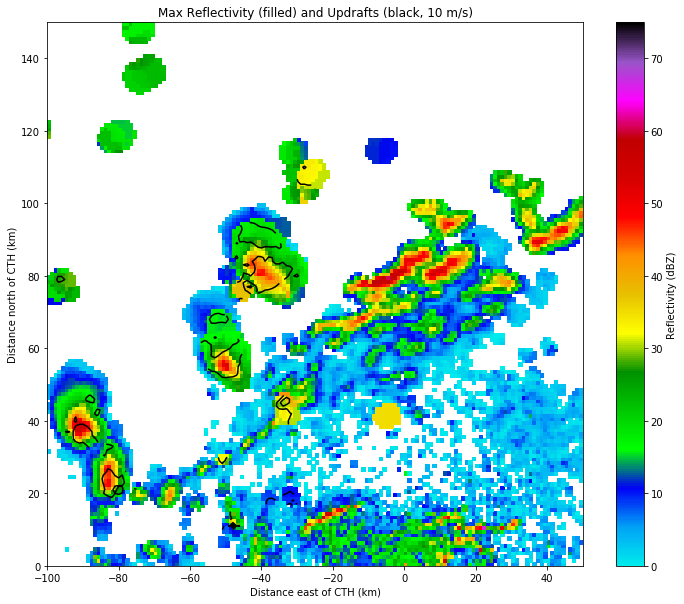

In [27]:
fig = plt.figure(figsize=(12, 10))
fig.set_facecolor('w')
DZcomp = np.amax(pyart_grid.fields['reflectivity']['data'], axis=0)
x, y = np.meshgrid(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'])
cs = plt.pcolormesh(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'],
                    DZcomp, vmin=0, vmax=75, cmap='pyart_NWSRef')
Wcomp = np.amax(pyart_grid.fields['upward_air_velocity']['data'], axis=0)
plt.contour(x, y, Wcomp, levels=[1, 5, 10, 15, 20], colors=['k', 'k', 'k'])
plt.xlim(-100, 50)
plt.ylim(0, 150)
plt.colorbar(cs, label='Reflectivity (dBZ)')
plt.title('Max Reflectivity (filled) and Updrafts (black, 10 m/s)')
plt.xlabel('Distance east of CTH (km)')
plt.ylabel('Distance north of CTH (km)')

In [40]:
pyart_grid.point_x['data']

array([[[-100000.,  -99000.,  -98000., ...,   48000.,   49000.,
           50000.],
        [-100000.,  -99000.,  -98000., ...,   48000.,   49000.,
           50000.],
        [-100000.,  -99000.,  -98000., ...,   48000.,   49000.,
           50000.],
        ...,
        [-100000.,  -99000.,  -98000., ...,   48000.,   49000.,
           50000.],
        [-100000.,  -99000.,  -98000., ...,   48000.,   49000.,
           50000.],
        [-100000.,  -99000.,  -98000., ...,   48000.,   49000.,
           50000.]],

       [[-100000.,  -99000.,  -98000., ...,   48000.,   49000.,
           50000.],
        [-100000.,  -99000.,  -98000., ...,   48000.,   49000.,
           50000.],
        [-100000.,  -99000.,  -98000., ...,   48000.,   49000.,
           50000.],
        ...,
        [-100000.,  -99000.,  -98000., ...,   48000.,   49000.,
           50000.],
        [-100000.,  -99000.,  -98000., ...,   48000.,   49000.,
           50000.],
        [-100000.,  -99000.,  -98000., ...,   48